<a href="https://colab.research.google.com/github/vircsinger625/Onlab_2020_2/blob/main/%C3%96nlab_Mnist01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://colab.research.google.com/drive/1B5KQvPySqYEa6XicRHdOwgv8fN1BrCgQ#scrollTo=ZJ-hYN00t2E2

https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

https://github.com/AvivSham/Pytorch-MNIST-colab/blob/master/Pytorch_MNIST.ipynb

In [1]:
%matplotlib inline

In [ ]:
!pip install torch
!pip install torchvision

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms

import itertools
import time

from torch.autograd import Variable

print(torch.__version__)

1.6.0+cu101


In [4]:
# Python 2/3 compatibility
from __future__ import print_function, division

import numpy as np
import matplotlib.pyplot as plt

# functions to show an image
def imshow(img):  #:param img: (PyTorch Tensor)
    img = img / 2 + 0.5                           # unnormalize
    npimg = img.numpy()                           # Convert tensor to numpy array
    plt.imshow(np.transpose(npimg, (1, 2, 0)))    # Color channel first -> color channel last
    plt.show()

In [5]:
seed = 42
np.random.seed(seed)

if torch.cuda.is_available():
  torch.backends.cudnn.deterministic = True    # Make CuDNN Determinist
  torch.cuda.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Define default device, we should use the GPU (cuda) if available

In [6]:
input_size = 784      #  img_size = (28,28) ---> 28*28=784 in total
hidden_size = 100     # number of nodes at hidden layer
num_classes = 10      # number of output classes discrete range [0,9]
num_epochs = 1        # number of times which the entire dataset is passed throughout the model
batch_size = 100        # the size of input data took for one iteration
lr = 1e-3            # size of step 1e-3 = 0.001

In [ ]:
#title Downloading MNIST data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))]) #BW images https://stackoverflow.com/questions/59218671/runtimeerror-output-with-shape-1-224-224-doesnt-match-the-broadcast-shape

train_data = dsets.MNIST(root = './data', train = True, transform = transform, download = True)

tv_data= dsets.MNIST(root = './data', train = False, transform = transform)
test_data, val_data = torch.utils.data.random_split(tv_data, [5000, 5000], generator=torch.Generator().manual_seed(42))

In [8]:
type(test_data)

torch.utils.data.dataset.Subset

In [9]:
#title Loading the data

train_gen = torch.utils.data.DataLoader(dataset = train_data,
                                        batch_size = batch_size,
                                        shuffle = True)

test_gen = torch.utils.data.DataLoader(dataset = test_data,
                                      batch_size = batch_size, 
                                      shuffle = False)


val_gen = torch.utils.data.DataLoader(dataset = val_data,
                                      batch_size = batch_size, 
                                      shuffle = False)

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

In [17]:
all_data = len(train_data)+len(test_data)+len(val_data)

print('Train Data: \t %.3f%%' %torch.true_divide(100*len(train_data),all_data), '\t Number of images: ', len(train_data))
print('Test  Data: \t %.3f%%' %torch.true_divide(100*len(test_data),all_data), '\t Number of images:  ', len(test_data))
print('Valid Data: \t %.3f%%' %torch.true_divide(100*len(val_data),all_data), '\t Number of images:  ', len(val_data))

Train Data: 	 85.714% 	 Number of images:  60000
Test  Data: 	 7.143% 	 Number of images:   5000
Valid Data: 	 7.143% 	 Number of images:   5000


TRAIN IMAGES



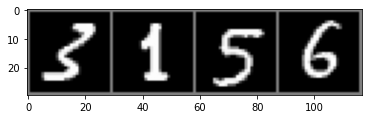

         3          1          5          6
TEST IMAGES


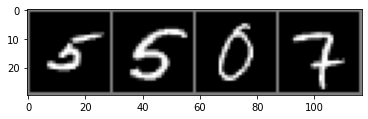

         5          5          0          7
VALIDATION IMAGES


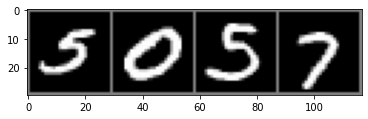

         5          0          5          7


In [11]:
# get some random training images

disImgs = 4

print('TRAIN IMAGES')
dataiter = iter(train_gen)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[0:disImgs,:,:,:], nrow = 5, padding = 1))
print(' '.join('%10s' % classes[labels[j]] for j in range(disImgs)))

print('TEST IMAGES')
dataiter_test = iter(test_gen)
images, labels = dataiter_test.next()
imshow(torchvision.utils.make_grid(images[0:disImgs,:,:,:], nrow = 5, padding = 1))
print(' '.join('%10s' % classes[labels[j]] for j in range(disImgs)))

print("VALIDATION IMAGES")
dataiter_val = iter(val_gen)
images, labels = dataiter_val.next()
imshow(torchvision.utils.make_grid(images[0:disImgs,:,:,:], nrow = 5, padding = 1))
print(' '.join('%10s' % classes[labels[j]] for j in range(disImgs)))

In [12]:
#title Define model class

class Net(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super(Net,self).__init__()
    self.fc1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.fc2 = nn.Linear(hidden_size, num_classes)
  
  def forward(self,x):
    out = self.fc1(x)
    out = self.relu(out)
    out = self.fc2(out)
    return out

In [13]:
#title Build the model

net = Net(input_size, hidden_size, num_classes)
if torch.cuda.is_available():
  net.cuda()

In [14]:
#title Define loss-function & optimizer

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam( net.parameters(), lr=lr)

In [15]:
#title Training the model

for epoch in range(num_epochs):
  for i ,(images,labels) in enumerate(train_gen):
    images = Variable(images.view(-1,28*28)).cuda()
    labels = Variable(labels).cuda()
    
    optimizer.zero_grad()
    outputs = net(images)
    loss = loss_function(outputs, labels)
    loss.backward()
    optimizer.step()

    if (i+1) % 100 == 0:
      print('Epoch [%d/%d], Step [%d/%d], Loss: %.4f' 
            % (epoch+1, num_epochs, i+1, 
               torch.floor_divide(len(train_data), batch_size), #60000
               loss.data))

Epoch [1/1], Step [100/600], Loss: 0.4761
Epoch [1/1], Step [200/600], Loss: 0.4262
Epoch [1/1], Step [300/600], Loss: 0.3335
Epoch [1/1], Step [400/600], Loss: 0.5510
Epoch [1/1], Step [500/600], Loss: 0.1696
Epoch [1/1], Step [600/600], Loss: 0.2667


In [16]:
#Title Evaluating the accuracy of the model

correct = 0
total = 0
for images,labels in test_gen:
  images = Variable(images.view(-1,28*28)).cuda()
  labels = labels.cuda()
  
  output = net(images)
  _, predicted = torch.max(output,1)
  correct += (predicted == labels).sum()
  total += labels.size(0)

print('Accuracy of the model: %.3f %%' %(torch.true_divide((100*correct),(total+1)))) 

Accuracy of the model: 93.001 %
